## Imports

In [6]:
import os
import json
import random
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet50, ResNet50_Weights
from torchvision import transforms

# NOTES

Number of data samples used for training are 20,000 samples and validation samples are 4000

All 80 classes have been used for training, which can be used as needed

**Preprocessing**

The Images have been cropped to involve only the corresponding objects from the entire images through bounding boxes information

The cropped images are then preprocessed to (64*64) and are also grayscaled and transformation is applied

ResNet50 default pretrained model is utilized to extract features of the corresponding transformed image. Feature shape is (2048,1)

**Neural Network**

There are k classes, and k binary classification models are initialized with random weights

A simple NN with 1 hidden layer and sigmoid activation has been applied to get the corresponding predictions
so total no. of parameters per model = 2048

The optimization and weights update happen according to the bi-level optimization objective as mentioned

The Inner loss function involves optimizing the weights of each and every model for k classes according to the objective

In Outer loss function objective, lamda values are updated from the taken maximum loss function value when calculated on the validation data

**Results**

Graphs are plotted as per the requirement and loss functions are tracked

Trained happened for 200 epochs

Note that since all 80 available classes have been used, training time was longer and lamda values are many i.e 80 possible values, so plotted a kernal density estimate graph

**THANKS**

## Hyperparameters

In [7]:
# Number of train and validation Samples
n = 20000
m = 4000

# Number of features of image
n_features = 2048

# Number of classes
k = 80

# Dataset original dir
train_imgs_dir = './../data/train2014/'
val_imgs_dir = './../data/val2014/'

#Intermediate data dir
train_data_dir = './../data/train4/'
val_data_dir = './../data/val4/'

if not os.path.exists(train_data_dir):
    os.makedirs(train_data_dir)
    os.makedirs(val_data_dir)

### Loading Annotations File

In [8]:
with open('./../data/annotations/instances_val2014.json') as f:
    val_data = json.load(f)

with open('./../data/annotations/instances_train2014.json') as f:
    train_data = json.load(f)
    

### Generate Intermediate data

In [9]:
def generate_intermediate_data(data, imgs_dir, result_dir, samples):
    count = samples
    for i in tqdm(range(80000)):
        ann_data = data['annotations'][i]
        category_id = ann_data['category_id']
        if(category_ids[category_id]<=k):
            count-=1
            img_id = ann_data['image_id']
            id_list  = {item['id']: item for item in data['images']}
            image_data = id_list.get(img_id)
            
            image = Image.open(imgs_dir + image_data['file_name'])
            x, y, w, h = ann_data['bbox']
            cropped_image = image.crop((x, y, x + w, y + h))
            try:
                cropped_image.save(result_dir + str(img_id) + '_' + str(category_ids[category_id]) + '.jpg')
            except:
                continue
        if(count==0):
            break
            # print(image_data['file_name'] + " object is too small")

In [10]:
random.shuffle(train_data['annotations'])
random.shuffle(val_data['annotations'])

count = 0
category_ids = {}
for cat in train_data['categories']:
    category_ids[cat['id']] = count
    count+=1


generate_intermediate_data(train_data, train_imgs_dir, train_data_dir, n)
generate_intermediate_data(val_data, val_imgs_dir, val_data_dir, m)

100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [01:47<00:00, 37.33it/s]


### Get Image features

In [11]:
# Choose your ResNet model
model = resnet50(weights=ResNet50_Weights.DEFAULT)

# Freeze the convolutional layers (optional)
for param in model.parameters():
    param.requires_grad = False  # Prevents these layers from being updated during training

# Define the feature extractor (excluding the final classification layers)
feature_extractor = nn.Sequential(*list(model.children())[:-1])

# Define the transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)), 
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
])

### Creation of Train,Val data with extracted image features array

In [12]:
x_train = []
y_train = []


# Extract features from an image
with torch.no_grad():
    for file in tqdm(os.listdir(train_data_dir)):

        image = Image.open(train_data_dir + file)
    
        # Apply the transformations
        image = transform(image).unsqueeze(0)  # Add an extra dimension for the batch size
        
        x_train.append(feature_extractor(image).view(2048,1))
        y_class = np.full(k, -1)
        category = int(file.split('_')[1].split('.')[0])
        y_class[category] = 1
        y_train.append(y_class)

n = len(os.listdir(train_data_dir))
x_train = np.array(x_train)
x_train = np.reshape(x_train, (n, n_features))
y_train = np.array(y_train).T

100%|██████████████████████████████████████████████████████████████████████████| 18512/18512 [2:02:15<00:00,  2.52it/s]


In [13]:
x_val = []
y_val = []


# Extract features from an image
with torch.no_grad():
    for file in tqdm(os.listdir(val_data_dir)):

        image = Image.open(val_data_dir + file)
    
        # Apply the transformations
        image = transform(image).unsqueeze(0)  # Add an extra dimension for the batch size
        
        x_val.append(feature_extractor(image).view(2048,1))
        y_class = np.full(k, -1)
        category = int(file.split('_')[1].split('.')[0])
        y_class[category] = 1
        y_val.append(y_class)

m = len(os.listdir(val_data_dir))
x_val = np.array(x_val)
x_val = np.reshape(x_val, (m, n_features))
y_val = np.array(y_val).T

100%|██████████████████████████████████████████████████████████████████████████████| 3847/3847 [05:01<00:00, 12.75it/s]


# Bi-Level Optimization

### Simple Neural Network with 1 layer and sigmoid activation

In [50]:
class NeuralNetwork:
    def __init__(self, input_size, alpha=0.01):
        self.input_size = input_size
        self.weights = np.random.randn(input_size, 1)  # Initialize weights randomly
        # self.bias = np.random.randn(1,1)  # Initialize bias randomly
        self.alpha = alpha  # Learning rate

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        return x * (1 - x)

    def forward(self, X):
        # self.z = np.dot(X, self.weights) + self.bias
        self.z = np.dot(X, self.weights)
        self.activation = self.sigmoid(self.z)
        return self.activation

    def backward(self, X, y, output):
        # Compute gradient of loss with respect to weights and bias

        self.error = output - y
        d_weights = np.dot(X.T, self.error * self.sigmoid_derivative(output))
        # d_bias = np.sum(self.error * self.sigmoid_derivative(output))


        self.weights -= self.alpha * d_weights
        # self.bias -= self.alpha * d_bias

    def train(self, X, y, epochs=100):
        for epoch in range(epochs):
            output = self.forward(X)
            self.backward(X, y, output)
            # print(output, y)

            # Compute binary cross-entropy loss
            loss = -np.mean(y * np.log(output) + (1 - y) * np.log(1 - output))

            # if epoch % 10 == 0:
            print(f'Epoch {epoch}: Loss {loss}')

    def predict(self, X):
        return np.round(self.forward(X))


    def get_params(self):
        return self.weights

    def update_params(self,weights):
        self.weights -= self.alpha * weights

In [51]:
def BCELoss(y_pred, y):
    epsilon = 1e-15
    loss = -np.mean(y * np.log(y_pred + epsilon) + (1 - y) * np.log(1 - y_pred + epsilon))
    return loss

In [52]:
learning_rate = 0.0001
learning_rate2 = 0.00001
reg_lamda = 0.01

models = [NeuralNetwork(n_features, alpha=learning_rate)] * k
lamda = np.random.randn(k,1)

In [53]:
y_train = y_train.reshape(k,n,1)
y_val = y_val.reshape(k,m,1)

### Training Code

In [54]:
outer_losses = []
inner_losses = []

x_train_T = x_train.T
x_val_T = x_val.T

for epoch in tqdm(range(200)):
    inner_loss = 0
    
    for c in tqdm(range(k)):
        outputs = models[c].forward(x_train)
        loss = BCELoss(outputs, y_train[c])
        inner_loss += lamda[c] * loss
        weights = models[c].get_params()
        inner_loss += reg_lamda * np.sum(weights**2)
        z = outputs - y_train[c]
        d_w = weights + lamda[c]*np.dot(x_train_T, outputs - y_train[c])*(1/n)
        models[c].update_params(d_w)
    print(inner_loss) 
    inner_losses.append(inner_loss)
    
    outer_loss = 0
    opt_c = 0
    opt_outputs = 0
    for c in tqdm(range(k)):
        outputs = models[c].forward(x_val)
        loss = BCELoss(outputs, y_val[c])
        if(loss>=outer_loss):
            opt_c = c
            opt_outputs = outputs
            outer_loss = loss
    d_l = np.zeros((k,1))
    print(opt_c)

    val_gradient = np.dot(x_val_T, opt_outputs - y_val[opt_c]).T
    for c in range(k):
        outputs = models[c].forward(x_train)
        d_l[c] = np.dot(val_gradient, np.dot(x_train_T, outputs-y_train[c]))
    lamda -= learning_rate2 * 1/(n*m) * d_l
    print(outer_loss)
    outer_losses.append(outer_loss)
        

100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:17<00:00,  4.61it/s]


[1653.314986]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 38.94it/s]


78
9.066913365015825


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:16<00:00,  4.72it/s]


[1627.00017654]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 43.27it/s]


78
8.990674788618275


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:17<00:00,  4.53it/s]


[1601.10238595]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 40.85it/s]


78
8.915123439051555


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:17<00:00,  4.55it/s]


[1575.61500884]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 40.41it/s]


78
8.840253830322865


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:17<00:00,  4.65it/s]


[1550.53155135]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 39.71it/s]


78
8.766060518272496


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:20<00:00,  3.95it/s]


[1525.84561671]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 42.03it/s]


78
8.692538077243993


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:22<00:00,  3.53it/s]


[1501.55091226]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 44.21it/s]


78
8.619681152180787


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:23<00:00,  3.42it/s]


[1477.64124379]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 44.94it/s]


78
8.547484413322602


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:23<00:00,  3.44it/s]


[1454.11051612]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 46.70it/s]


78
8.475942574004364


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:23<00:00,  3.42it/s]


[1430.95272931]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 43.72it/s]


78
8.40505039301067


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:23<00:00,  3.38it/s]


[1408.16197938]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 41.86it/s]


78
8.334802665184993


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:23<00:00,  3.35it/s]


[1385.73245518]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 42.16it/s]


78
8.2651942283773


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:23<00:00,  3.43it/s]


[1363.65843748]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 41.85it/s]


78
8.196219959127909


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:21<00:00,  3.80it/s]


[1341.93429805]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 43.26it/s]


78
8.127874773224182


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:22<00:00,  3.61it/s]


[1320.55449702]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 41.35it/s]


78
8.060153626939297


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:22<00:00,  3.55it/s]


[1299.51358275]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 45.78it/s]


78
7.993051514447797


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:23<00:00,  3.45it/s]


[1278.8061895]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 43.04it/s]


78
7.92656346847906


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:22<00:00,  3.58it/s]


[1258.42703653]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 42.51it/s]


78
7.860684561084993


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:22<00:00,  3.53it/s]


[1238.37092676]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 41.92it/s]


78
7.795409900937449


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:19<00:00,  4.02it/s]


[1218.63274511]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 40.69it/s]


78
7.730734634906133


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:17<00:00,  4.45it/s]


[1199.20745763]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 41.35it/s]


78
7.666653947407986


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:18<00:00,  4.41it/s]


[1180.09010987]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 40.02it/s]


78
7.603163059432566


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:17<00:00,  4.56it/s]


[1161.27582587]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 40.04it/s]


78
7.540257228756049


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:18<00:00,  4.36it/s]


[1142.75980673]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 43.46it/s]


78
7.477931749790768


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:18<00:00,  4.42it/s]


[1124.53732951]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 40.22it/s]


78
7.416181952425367


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:18<00:00,  4.40it/s]


[1106.60374594]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 38.57it/s]


78
7.355003203001071


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:17<00:00,  4.57it/s]


[1088.95448135]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 39.60it/s]


78
7.294390902821584


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:18<00:00,  4.30it/s]


[1071.58503338]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 40.55it/s]


78
7.234340488707521


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:17<00:00,  4.59it/s]


[1054.49097093]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 41.01it/s]


78
7.174847432006178


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:18<00:00,  4.40it/s]


[1037.667933]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 39.20it/s]


78
7.115907238978951


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:18<00:00,  4.33it/s]


[1021.11162752]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 39.62it/s]


78
7.057515450048882


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:17<00:00,  4.48it/s]


[1004.81783039]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 42.21it/s]


78
6.999667639568073


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:18<00:00,  4.29it/s]


[988.78238428]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 39.83it/s]


78
6.94235941573909


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:17<00:00,  4.48it/s]


[973.00119764]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 41.67it/s]


78
6.885586420215412


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:17<00:00,  4.54it/s]


[957.47024364]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 40.74it/s]


78
6.829344327704991


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:18<00:00,  4.44it/s]


[942.18555914]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 43.03it/s]


78
6.773628845929867


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:18<00:00,  4.37it/s]


[927.1432437]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 41.36it/s]


78
6.71843571518431


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:18<00:00,  4.43it/s]


[912.33945856]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 40.67it/s]


78
6.663760708068246


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:18<00:00,  4.43it/s]


[897.77042569]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 41.55it/s]


78
6.609599629369837


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:18<00:00,  4.34it/s]


[883.43242682]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 39.35it/s]


78
6.555948315584259


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:18<00:00,  4.39it/s]


[869.32180248]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 39.66it/s]


78
6.502802634852909


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:20<00:00,  3.98it/s]


[855.43495111]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 35.33it/s]


78
6.450158486550388


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:19<00:00,  4.04it/s]


[841.76832808]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 33.17it/s]


78
6.398011801120565


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:20<00:00,  3.85it/s]


[828.31844485]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 33.16it/s]


78
6.3463585397766344


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:20<00:00,  3.87it/s]


[815.08186804]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 34.13it/s]


78
6.295194694267233


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:20<00:00,  3.87it/s]


[802.0552186]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 36.69it/s]


78
6.2445162866122725


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:17<00:00,  4.53it/s]


[789.23517089]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 39.97it/s]


78
6.194319368871288


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:17<00:00,  4.46it/s]


[776.61845189]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 38.18it/s]


78
6.144600022880518


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:17<00:00,  4.47it/s]


[764.20184034]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 39.03it/s]


78
6.095354360032149


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:18<00:00,  4.36it/s]


[751.98216593]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 40.60it/s]


78
6.046578521005753


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:18<00:00,  4.44it/s]


[739.9563085]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 41.79it/s]


78
5.998268675555459


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:17<00:00,  4.52it/s]


[728.12119722]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 39.20it/s]


78
5.9504210222595315


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:18<00:00,  4.38it/s]


[716.47380984]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 40.15it/s]


78
5.903031788292915


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:18<00:00,  4.41it/s]


[705.01117189]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 40.96it/s]


78
5.856097229195647


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:18<00:00,  4.32it/s]


[693.73035597]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 40.16it/s]


78
5.809613628641712


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:17<00:00,  4.57it/s]


[682.62848095]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 39.45it/s]


78
5.763577298211445


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:17<00:00,  4.45it/s]


[671.7027113]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 41.15it/s]


78
5.717984577177563


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:18<00:00,  4.41it/s]


[660.95025629]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 40.03it/s]


78
5.6728318322689315


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:18<00:00,  4.40it/s]


[650.36836936]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 42.22it/s]


78
5.628115457464139


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:18<00:00,  4.39it/s]


[639.95434737]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 39.38it/s]


78
5.583831873769161


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:18<00:00,  4.38it/s]


[629.70552995]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 38.38it/s]


78
5.539977528997486


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:18<00:00,  4.35it/s]


[619.61929877]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 40.41it/s]


78
5.496548897567025


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:18<00:00,  4.35it/s]


[609.69307693]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 39.36it/s]


78
5.453542480283971


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:18<00:00,  4.43it/s]


[599.92432829]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 40.52it/s]


78
5.4109548041375035


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:17<00:00,  4.45it/s]


[590.31055679]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 40.01it/s]


78
5.3687824220904385


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:18<00:00,  4.42it/s]


[580.84930587]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 40.51it/s]


78
5.327021912880102


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:18<00:00,  4.44it/s]


[571.53815782]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 43.61it/s]


78
5.285669880813669


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:17<00:00,  4.48it/s]


[562.37473314]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 37.43it/s]


78
5.244722955570324


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:18<00:00,  4.42it/s]


[553.35668998]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 44.35it/s]


78
5.204177792003821


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:17<00:00,  4.48it/s]


[544.48172352]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 40.64it/s]


78
5.164031069947637


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:17<00:00,  4.45it/s]


[535.7475654]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 43.60it/s]


78
5.124279494021996


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:18<00:00,  4.44it/s]


[527.1519831]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 41.77it/s]


78
5.084919793443832


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:18<00:00,  4.42it/s]


[518.69277945]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 40.21it/s]


78
5.045948721837345


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:17<00:00,  4.49it/s]


[510.367792]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 41.05it/s]


78
5.007363057047625


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:18<00:00,  4.40it/s]


[502.17489249]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 41.58it/s]


78
4.969159600956976


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:18<00:00,  4.38it/s]


[494.11198634]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 39.69it/s]


78
4.931335179302012


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:18<00:00,  4.44it/s]


[486.17701208]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 39.26it/s]


78
4.893886641492874


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:18<00:00,  4.37it/s]


[478.36794085]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 39.56it/s]


78
4.856810860435584


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:18<00:00,  4.42it/s]


[470.68277587]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 42.29it/s]


78
4.820104732355688


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:18<00:00,  4.31it/s]


[463.11955193]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 42.57it/s]


78
4.783765176623322


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:18<00:00,  4.32it/s]


[455.67633491]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 40.96it/s]


78
4.747789135581449


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:17<00:00,  4.47it/s]


[448.35122128]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 40.21it/s]


78
4.712173574375097


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:17<00:00,  4.59it/s]


[441.14233759]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 41.17it/s]


78
4.6769154807829185


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:17<00:00,  4.53it/s]


[434.04784005]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 41.95it/s]


78
4.642011865050506


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:17<00:00,  4.52it/s]


[427.06591402]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 38.67it/s]


78
4.607459759726046


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:17<00:00,  4.45it/s]


[420.19477353]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 40.18it/s]


78
4.573256219497181


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:18<00:00,  4.25it/s]


[413.43266089]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 36.97it/s]


78
4.539398321029973


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:18<00:00,  4.24it/s]


[406.77784619]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 38.90it/s]


78
4.505883162810037


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:18<00:00,  4.25it/s]


[400.22862688]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 39.49it/s]


78
4.4727078649852245


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:19<00:00,  4.17it/s]


[393.78332735]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 39.25it/s]


78
4.43986956920992


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:19<00:00,  4.16it/s]


[387.44029847]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 38.15it/s]


78
4.407365438491456


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:18<00:00,  4.23it/s]


[381.19791719]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 40.86it/s]


78
4.375192657038149


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:19<00:00,  4.18it/s]


[375.05458616]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 39.76it/s]


78
4.343348430109132


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:19<00:00,  4.17it/s]


[369.00873326]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 41.34it/s]


78
4.311829983865682


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:19<00:00,  4.18it/s]


[363.05881124]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 34.89it/s]


78
4.280634565224674


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:19<00:00,  4.10it/s]


[357.20329734]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 42.97it/s]


78
4.24975944171331


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:18<00:00,  4.22it/s]


[351.44069286]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 41.84it/s]


78
4.219201901325715


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:19<00:00,  4.18it/s]


[345.76952282]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 41.20it/s]


78
4.188959252381186


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:18<00:00,  4.21it/s]


[340.18833556]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 40.88it/s]


78
4.1590288233839185


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:19<00:00,  4.16it/s]


[334.69570238]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 40.43it/s]


78
4.129407962884512


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:19<00:00,  4.17it/s]


[329.29021718]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 43.62it/s]


78
4.10009403934292


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:18<00:00,  4.24it/s]


[323.97049611]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 40.34it/s]


78
4.071084440993011


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:19<00:00,  4.18it/s]


[318.73517719]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 31.68it/s]


78
4.042376575708675


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:19<00:00,  4.18it/s]


[313.58291998]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 42.04it/s]


78
4.013967870871451


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:19<00:00,  4.14it/s]


[308.51240527]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 38.94it/s]


78
3.985855773239553


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:19<00:00,  4.18it/s]


[303.52233469]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 40.04it/s]


78
3.9580377488185277


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:18<00:00,  4.25it/s]


[298.61143041]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 42.07it/s]


78
3.9305112827332356


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:19<00:00,  4.19it/s]


[293.77843483]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 35.17it/s]


78
3.9032738791013055


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:19<00:00,  4.11it/s]


[289.02211023]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 38.30it/s]


78
3.876323060907997


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:19<00:00,  4.17it/s]


[284.34123846]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 38.39it/s]


78
3.8496563698824495


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:19<00:00,  4.12it/s]


[279.73462066]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 40.24it/s]


78
3.8232713663752977


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:19<00:00,  4.12it/s]


[275.20107692]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 39.77it/s]


78
3.7971656292375746


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:19<00:00,  4.10it/s]


[270.73944599]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 40.93it/s]


78
3.771336755701033


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:19<00:00,  4.17it/s]


[266.34858502]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 39.46it/s]


78
3.745782361259661


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:19<00:00,  4.11it/s]


[262.0273692]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 44.82it/s]


78
3.7205000795525476


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:19<00:00,  4.04it/s]


[257.77469154]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 31.42it/s]


78
3.69548756224795


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:18<00:00,  4.26it/s]


[253.58946255]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 38.55it/s]


78
3.6707424789286076


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:18<00:00,  4.21it/s]


[249.47060999]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 40.74it/s]


78
3.64626251697829


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:19<00:00,  4.14it/s]


[245.41707857]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 41.39it/s]


78
3.622045381469474


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:19<00:00,  4.17it/s]


[241.42782971]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 38.23it/s]


78
3.598088795052232


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:19<00:00,  4.12it/s]


[237.50184123]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 35.83it/s]


78
3.574390497844232


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:19<00:00,  4.14it/s]


[233.63810717]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 39.94it/s]


78
3.550948247321873


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:19<00:00,  4.17it/s]


[229.83563745]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 37.16it/s]


78
3.5277598182125165


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:19<00:00,  4.16it/s]


[226.09345766]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 37.26it/s]


78
3.504823002387771


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:19<00:00,  4.13it/s]


[222.41060883]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 40.83it/s]


78
3.4821356087578557


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:19<00:00,  4.21it/s]


[218.78614713]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 40.21it/s]


78
3.459695463166978


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:19<00:00,  4.13it/s]


[215.2191437]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 41.19it/s]


78
3.437500408289724


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:19<00:00,  4.15it/s]


[211.70868434]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 39.80it/s]


78
3.4155483035284293


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:19<00:00,  4.15it/s]


[208.25386934]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 37.71it/s]


78
3.39383702491154


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:18<00:00,  4.24it/s]


[204.85381324]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 41.03it/s]


78
3.3723644649928826


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:18<00:00,  4.22it/s]


[201.50764455]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 39.08it/s]


78
3.3511285327518747


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:19<00:00,  4.03it/s]


[198.21450561]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 40.87it/s]


78
3.330127153494648


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:19<00:00,  4.20it/s]


[194.97355232]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 40.04it/s]


78
3.309358268756025


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:19<00:00,  4.15it/s]


[191.78395393]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 37.58it/s]


78
3.2888198362023737


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:19<00:00,  4.18it/s]


[188.64489285]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 41.98it/s]


78
3.268509829535302


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:19<00:00,  4.16it/s]


[185.55556442]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 40.62it/s]


78
3.2484262383961617


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:19<00:00,  4.10it/s]


[182.51517671]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 40.83it/s]


78
3.2285670682713525


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:19<00:00,  4.17it/s]


[179.52295035]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 41.29it/s]


78
3.20893034039841


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:19<00:00,  4.12it/s]


[176.57811827]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 39.87it/s]


78
3.1895140916728413


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:19<00:00,  4.12it/s]


[173.67992557]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 41.07it/s]


78
3.1703163745557132


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:19<00:00,  4.12it/s]


[170.82762929]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 41.27it/s]


78
3.1513352569819437


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:18<00:00,  4.26it/s]


[168.02049821]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 38.83it/s]


78
3.1325688222693073


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:19<00:00,  4.16it/s]


[165.25781272]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 39.56it/s]


78
3.1140151690281086


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:19<00:00,  4.17it/s]


[162.53886457]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 41.92it/s]


78
3.09567241107153


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:19<00:00,  4.20it/s]


[159.86295675]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 41.07it/s]


78
3.077538677326612


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:19<00:00,  4.14it/s]


[157.22940324]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 38.76it/s]


78
3.0596121117458654


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:18<00:00,  4.24it/s]


[154.63752894]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 40.49it/s]


78
3.0418908732194936


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:19<00:00,  4.11it/s]


[152.08666938]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 39.31it/s]


78
3.0243731354881964


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:19<00:00,  4.15it/s]


[149.57617064]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 41.03it/s]


78
3.007057087056548


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:19<00:00,  4.19it/s]


[147.10538915]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 41.98it/s]


78
2.9899409311069416


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:18<00:00,  4.28it/s]


[144.67369153]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 41.88it/s]


78
2.973022885414055


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:18<00:00,  4.27it/s]


[142.28045441]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 41.30it/s]


78
2.956301182259857


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:19<00:00,  4.18it/s]


[139.92506432]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 42.16it/s]


78
2.9397740683490987


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:18<00:00,  4.21it/s]


[137.60691748]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 40.56it/s]


78
2.9234398047253216


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:19<00:00,  4.13it/s]


[135.32541967]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 41.17it/s]


78
2.9072966666873112


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:19<00:00,  4.20it/s]


[133.07998609]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 40.02it/s]


78
2.891342943706032


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:19<00:00,  4.12it/s]


[130.8700412]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 39.81it/s]


78
2.875576939342008


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:19<00:00,  4.09it/s]


[128.69501856]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 35.46it/s]


78
2.859996971163109


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:19<00:00,  4.12it/s]


[126.55436071]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 39.83it/s]


78
2.8446013706627813


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:19<00:00,  4.18it/s]


[124.44751902]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 34.90it/s]


78
2.8293884831786653


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:18<00:00,  4.26it/s]


[122.37395354]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 41.13it/s]


78
2.814356667811603


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:18<00:00,  4.28it/s]


[120.33313288]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 39.49it/s]


78
2.799504297345025


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:18<00:00,  4.23it/s]


[118.32453406]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 38.59it/s]


78
2.7848297581647024


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:18<00:00,  4.27it/s]


[116.34764238]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 41.73it/s]


78
2.770331450178838


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:19<00:00,  4.19it/s]


[114.4019513]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 39.17it/s]


78
2.756007786738511


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:19<00:00,  4.17it/s]


[112.48696228]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 39.72it/s]


78
2.7418571945584316


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:19<00:00,  4.17it/s]


[110.60218471]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 39.29it/s]


78
2.727878113638023


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:19<00:00,  4.16it/s]


[108.74713572]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 41.43it/s]


78
2.7140689971828045


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:18<00:00,  4.25it/s]


[106.92134012]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 40.29it/s]


78
2.7004283115260654


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:19<00:00,  4.09it/s]


[105.12433021]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 38.22it/s]


78
2.686954536050822


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:18<00:00,  4.28it/s]


[103.35564572]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 39.92it/s]


78
2.673646163112053


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:17<00:00,  4.51it/s]


[101.61483367]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 44.10it/s]


78
2.660501697959187


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:17<00:00,  4.57it/s]


[99.90144825]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 38.80it/s]


78
2.647519658658856


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:18<00:00,  4.40it/s]


[98.21505072]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 40.64it/s]


78
2.634698576017888


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:16<00:00,  4.74it/s]


[96.55520927]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 39.43it/s]


78
2.6220369935065424


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:17<00:00,  4.58it/s]


[94.92149896]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 39.90it/s]


78
2.609533467181961


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:17<00:00,  4.59it/s]


[93.31350155]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 40.46it/s]


78
2.5971865656118496


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:19<00:00,  4.09it/s]


[91.73080545]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 45.34it/s]


78
2.5849948697983747


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:19<00:00,  4.17it/s]


[90.17300559]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 38.85it/s]


78
2.572956973102259


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:18<00:00,  4.22it/s]


[88.63970329]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 42.29it/s]


78
2.561071481167076


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:19<00:00,  4.14it/s]


[87.13050623]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 40.74it/s]


78
2.5493370118437495


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:19<00:00,  4.16it/s]


[85.64502826]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 35.09it/s]


78
2.5377521951152215


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:18<00:00,  4.23it/s]


[84.18288937]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 40.43it/s]


78
2.526315673021311


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:19<00:00,  4.17it/s]


[82.74371558]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 39.68it/s]


78
2.51502609958375


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:19<00:00,  4.18it/s]


[81.32713882]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 40.98it/s]


78
2.5038821407313843


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:19<00:00,  4.18it/s]


[79.93279686]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 40.20it/s]


78
2.4928824742255427


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:19<00:00,  4.16it/s]


[78.5603332]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 41.23it/s]


78
2.482025789585561


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:19<00:00,  4.16it/s]


[77.20939699]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 41.62it/s]


78
2.4713107880144736


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:19<00:00,  4.18it/s]


[75.87964295]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 34.15it/s]


78
2.460736182324844


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:19<00:00,  4.20it/s]


[74.57073126]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 40.43it/s]


78
2.4503006968647596


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:18<00:00,  4.22it/s]


[73.2823275]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 39.72it/s]


78
2.4400030674439583


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:18<00:00,  4.27it/s]


[72.01410252]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 39.58it/s]


78
2.429842041260107


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:19<00:00,  4.17it/s]


[70.76573241]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 43.60it/s]


78
2.419816376825214


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:19<00:00,  4.17it/s]


[69.53689839]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 40.75it/s]


78
2.4099248438921865


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:19<00:00,  4.16it/s]


[68.32728672]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 41.36it/s]


78
2.4001662233815146


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:18<00:00,  4.30it/s]


[67.13658864]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 40.95it/s]


78
2.3905393073081003


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:18<00:00,  4.28it/s]


[65.96450028]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 40.96it/s]


78
2.3810428987082055


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:19<00:00,  4.10it/s]


[64.81072259]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 37.58it/s]


78
2.3716758115665426


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:18<00:00,  4.23it/s]


[63.67496124]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 36.94it/s]


78
2.3624368707434873


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:18<00:00,  4.30it/s]


[62.55692659]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 39.81it/s]


78
2.3533249119024244


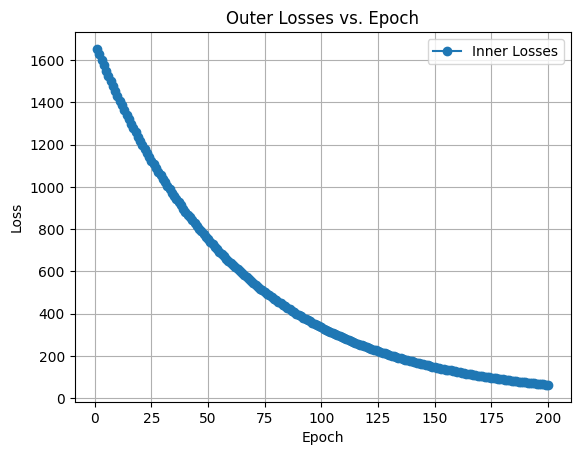

In [57]:
epochs = range(1, len(inner_losses) + 1)


# Plotting the graph
plt.plot(epochs, inner_losses, marker='o', linestyle='-', label='Inner Losses')
# plt.plot(epochs, outer_losses, marker='o', linestyle='-', label='Outer Losses')

plt.title('Outer Losses vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()  # Show legend with labels
plt.grid(True)
plt.savefig('inner_20k.jpg')
plt.show()

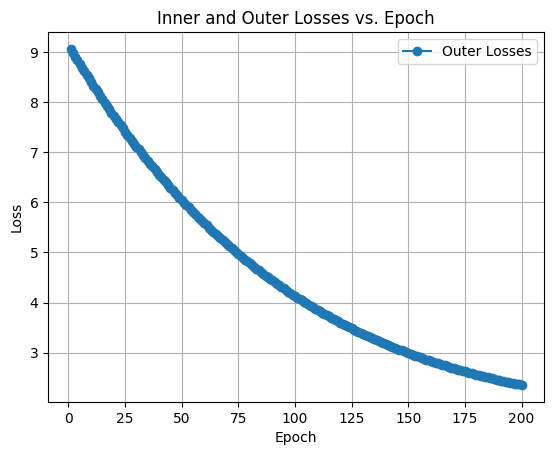

In [58]:
epochs = range(1, len(inner_losses) + 1)


# Plotting the graph
# plt.plot(epochs, inner_losses, marker='o', linestyle='-', label='Inner Losses')
plt.plot(epochs, outer_losses, marker='o', linestyle='-', label='Outer Losses')

plt.title('Inner and Outer Losses vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()  # Show legend with labels
plt.grid(True)
plt.savefig('temp2_20k.jpg')
plt.show()

/tmp/ipykernel_3336432/1850570225.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_flat, shade=True)


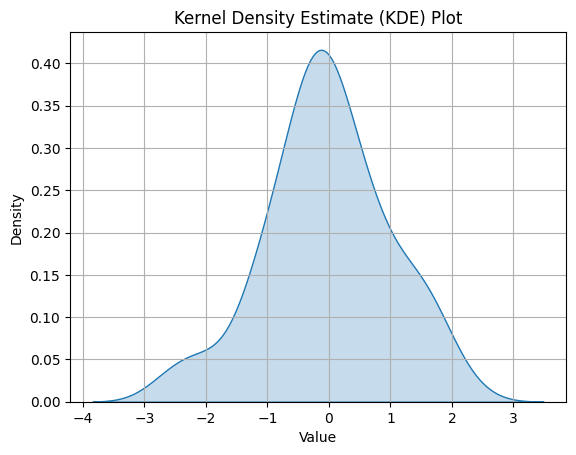

<Figure size 640x480 with 0 Axes>

In [74]:
import seaborn as sns
data_flat = lamda.flatten()

# Create a KDE plot
sns.kdeplot(data_flat, shade=True)
plt.title('Kernel Density Estimate (KDE) Plot')
plt.xlabel('Value')
plt.ylabel('Density')
plt.grid(True)
plt.show()
plt.savefig('lamda.jpg')

In [72]:
val_data['categories']

[{'supercategory': 'person', 'id': 1, 'name': 'person'},
 {'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'},
 {'supercategory': 'vehicle', 'id': 3, 'name': 'car'},
 {'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'},
 {'supercategory': 'vehicle', 'id': 5, 'name': 'airplane'},
 {'supercategory': 'vehicle', 'id': 6, 'name': 'bus'},
 {'supercategory': 'vehicle', 'id': 7, 'name': 'train'},
 {'supercategory': 'vehicle', 'id': 8, 'name': 'truck'},
 {'supercategory': 'vehicle', 'id': 9, 'name': 'boat'},
 {'supercategory': 'outdoor', 'id': 10, 'name': 'traffic light'},
 {'supercategory': 'outdoor', 'id': 11, 'name': 'fire hydrant'},
 {'supercategory': 'outdoor', 'id': 13, 'name': 'stop sign'},
 {'supercategory': 'outdoor', 'id': 14, 'name': 'parking meter'},
 {'supercategory': 'outdoor', 'id': 15, 'name': 'bench'},
 {'supercategory': 'animal', 'id': 16, 'name': 'bird'},
 {'supercategory': 'animal', 'id': 17, 'name': 'cat'},
 {'supercategory': 'animal', 'id': 18, 'name': 'dog'},